In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from slam.motion_models.odometry_model import odometry_sample, odometry_command
from slam.utils import normalize_angle, sample_normal_distribution
from slam.robot import BaseRobot
from slam.map import LandmarkMap
from slam.data import read_simple_world, read_simple_data
from slam.particle_filter import ParticleFilter, low_variance_resampling

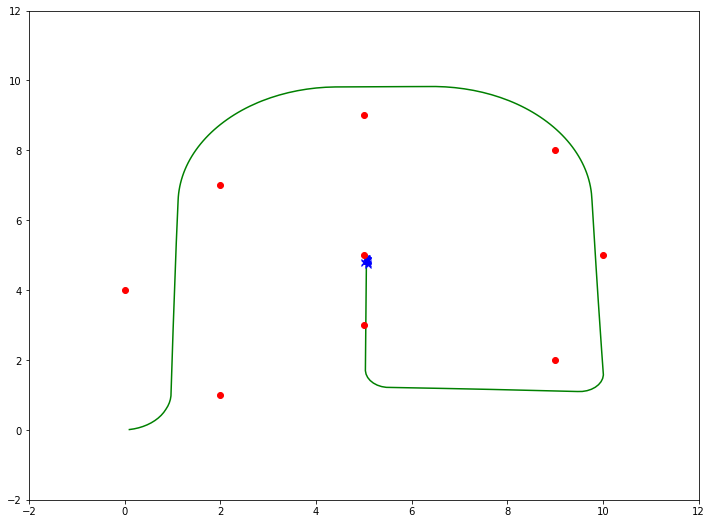

In [73]:
robot = BaseRobot(0, 0, 0, odometry_command)

odometry, sensor = read_simple_data('../data/simple/sensor_data.dat')
landmarks = read_simple_world('../data/simple/world.dat')

commands = [np.array(odom).T for odom in odometry]

pf = ParticleFilter(robot.pose, 25, odometry_sample, \
                    sample_normal_distribution, low_variance_resampling)
landmark_map = LandmarkMap(landmarks)

fig = plt.figure(figsize=(12, 9))
plt.xlim((-2, 12))
plt.ylim((-2, 12))

true_x = []
true_y = []
pf_x = []
pf_y = []

# Odometry noise
# rot1 variance, trans variance, rot2 variance
odometry_noise = (0.01, 0.05, 0.01)

# Sensor noise
# range variance, bearing variance
sensor_noise = (0.1, 0.1)

odom_sens_data = zip(odometry, sensor)
# For debugging
# odom_sens_data = list(zip(odometry, sensor))[:100]

for command, readings in odom_sens_data:
    robot.motion_command(command)
    
    true_x.append(robot.pose.item(0))
    true_y.append(robot.pose.item(1))
    
    pf.predict(command, odometry_noise)
    # Comment out correction and resampling steps to see raw odometry
    pf.correct(readings, sensor_noise, landmark_map)
    pf.resample()
    
plt.plot(true_x, true_y, 'g')

for i, particle in enumerate(pf.particles):
    weight, pose = particle
    pf_x.append(pose.item(0))
    pf_y.append(pose.item(1))

plt.plot(pf_x, pf_y, 'bx')

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro')